# Text adventure game

This Python notebook builds a simple text advenutre game inspired by the [Adventuron Classroom](https://adventuron.io/classroom/) design by Chris Ainsley of Adventuron Software Limited.

The main components are:
1. __The parser__, which interprets the player's commands.
2. __The game__, which represents the world (a collection of __locations__ and __items__), and describes what the player sees.
3. __The data__, which you input to create your own unique game.

## The Game Class
The game keeps track of the state of the world, and describes what the player sees as they move through different locations.

In [13]:
class Game:
  """The Game class represents the world.  Internally, we use a 
     graph of Location objects and Item objects, which can be at a 
     Location or in the player's inventory.  Each locations has a set of
     exits which are the directions that a player can move to get to an
     adjacent location. The player can move from one location to another
     location by typing a command like "Go North".
  """

  def __init__(self, start_at):
    # start_at is the location in the game where the player starts
    self.curr_location = start_at
    self.curr_location.has_been_visited = True
    # inventory is the set of objects that the player has collected/
    self.inventory = {}
    self.is_married = False
    self.princess_has = []
    # Print the special commands associated with items in the game (helpful 
    # for debugging and for novice players).
    self.print_commands = True

  def describe(self):
    """Describe the current game state by first describing the current 
       location, then listing any exits, and then describing any objects
       in the current location."""
    self.describe_current_location()
    self.describe_exits()
    self.describe_items()

  def describe_current_location(self):
    """Describe the current location by printing its description field."""
    print(self.curr_location.description)

  def describe_exits(self):
    """List the directions that the player can take to exit from the current
       location."""
    exits = []
    for exit in self.curr_location.connections.keys():
      exits.append(exit.capitalize())
    if len(exits) > 0:
      print("Exits: ", end = '')
      print(*exits, sep = ", ",)
  
  def describe_items(self):
    """Describe what objects are in the current location."""
    if len(self.curr_location.items) > 0:
      print("You see: ")
      for item_name in self.curr_location.items:
        item = self.curr_location.items[item_name]
        print(item.description)
        if self.print_commands:
          special_commands = item.get_commands()
          for cmd in special_commands:
            print('\t', cmd)

  def add_to_inventory(self, item):
    """Add an item to the player's inventory."""
    self.inventory[item.name] = item
  
  def is_in_inventory(self,item):
    return item.name in self.inventory

  def get_items_in_scope(self):
    """Returns a list of items in the current location and in the inventory"""
    items_in_scope = []
    for item_name in self.curr_location.items:
      items_in_scope.append(self.curr_location.items[item_name])
    for item_name in self.inventory:
      items_in_scope.append(self.inventory[item_name])
    return items_in_scope

## Locations

Locations Locations are the places in the game that a player can visit.  They contain connects to other locations and items that the player can interact with.

In [14]:
class Location:
  """Locations are the places in the game that a player can visit.
     Internally they are represented nodes in a graph.  Each location stores
     a description of the location, any items in the location, its connections
     to adjacent locations, and any blocks that prevent movement to an adjacent
     location.  The connections is a dictionary whose keys are directions and
     whose values are the location that is the result of traveling in that 
     direction.  The travel_descriptions also has directions as keys, and its 
     values are an optional short desciption of traveling to that location.
  """
  def __init__(self, name, description, end_game=False):
    # A short name for the location
    self.name = name
    # A description of the location
    self.description = description
    # True if entering this location should end the game
    self.end_game = end_game
    # Dictionary mapping from directions to other Location objects
    self.connections = {}
    # Dictionary mapping from directions to text description of the path there
    self.travel_descriptions = {}
    # Dictionary mapping from item name to Item objects present in this location
    self.items = {}
    # Dictionary mapping from direction to Block object in that direction
    self.blocks = {}
    # Flag that gets set to True once this location has been visited by player
    self.has_been_visited = False

  def add_connection(self, direction, connected_location, travel_description=""):
    """Add a connection from the current location to a connected location.
       Direction is a string that the player can use to get to the connected
       location.  If the direction is a cardinal direction, then we also 
       automatically make a connection in the reverse direction."""
    self.connections[direction] = connected_location
    self.travel_descriptions[direction] = travel_description
    if direction == 'north':
      connected_location.connections["south"] = self
      connected_location.travel_descriptions["south"] = ""
    if direction == 'south':
      connected_location.connections["north"] = self
      connected_location.travel_descriptions["north"] = ""
    if direction == 'east':
      connected_location.connections["west"] = self
      connected_location.travel_descriptions["west"] = ""
    if direction == 'west':
      connected_location.connections["east"] = self
      connected_location.travel_descriptions["east"] = ""
    if direction == 'up':
      connected_location.connections["down"] = self
      connected_location.travel_descriptions["down"] = ""
    if direction == 'down':
      connected_location.connections["up"] = self
      connected_location.travel_descriptions["up"] = ""
    if direction == 'in':
      connected_location.connections["out"] = self
      connected_location.travel_descriptions["out"] = ""
    if direction == 'out':
      connected_location.connections["in"] = self
      connected_location.travel_descriptions["in"] = ""


  def add_item(self, name, item):
    """Put an item in this location."""
    self.items[name] = item

  def remove_item(self, item):
    """Remove an item from this location (for instance, if the player picks it
       up and puts it in their inventory)."""
    self.items.pop(item.name)


  def is_blocked(self, direction, game):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
        return False
    (block_description, preconditions) = self.blocks[direction]
    if check_preconditions(preconditions, game):
      # All the preconditions have been met.  You may pass.
      return False
    else: 
      # There are still obstalces to overcome or puzzles to solve.
      return True

  def get_block_description(self, direction):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
      return ""
    else:
      (block_description, preconditions) = self.blocks[direction]
      return block_description

  def add_block(self, blocked_direction, block_description, preconditions):
    """Create an obstacle that prevents a player from moving in the blocked 
       location until the preconditions are all met."""
    self.blocks[blocked_direction] = (block_description, preconditions)

## Checking Preconditions 
In text adventure games it's common to block a player's progress by creating blocks that prevent them from moving to a location.  For instance, a drawbridge might have a troll that you need to get rig of before you can cross into the castle, or a locked door might prevent you from entering a building until you have a key.  

This is a function that you can modify to include other preconditions.

In [15]:
def check_preconditions(preconditions, game, print_failure_reasons=True):
  """Checks whether the player has met all of the specified preconditions"""
  all_conditions_met = True
  for check in preconditions: 
    if check == "inventory_contains":
      item = preconditions[check]
      if not game.is_in_inventory(item):
        all_conditions_met = False
        if print_failure_reasons:
          print("You don't have the %s" % item.name)
    if check == "in_location":
      location = preconditions[check]
      if not game.curr_location == location:
        all_conditions_met = False
        if print_failure_reasons:
          print("You aren't in the correct location")
    if check == "location_has_item":
      item = preconditions[check]
      if not item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s isn't in this location" % item.name)
    if check == 'is_gone':
      item = preconditions[check]
      if(item.name in game.curr_location.items):
        all_conditions_met = False
    if check == 'princess_has':
      item = preconditions[check]
      if(item.name not in game.princess_has):
        all_conditions_met = False
    if check == 'is_lit':
      item = preconditions[check]
      if(not item.lit):
        all_conditions_met = False
    if check == 'is_wearing':
      item = preconditions[check]
      if(not item.is_wearing):
        all_conditions_met = False
    if check == 'is_married':
      if (game.is_married != preconditions[check]):
        all_conditions_met = False
    if check == 'is_unlocked':
      item = preconditions[check]
      if(not item.is_unlocked):
        all_conditions_met = False


      
    # todo - add other types of preconditions
  return all_conditions_met


## Items
Items are objects that a player can get, or scenery that a player can examine. We could also implement people as items.  

In [16]:
class Item:
  """Items are objects that a player can get, or scenery that a player can
     examine."""
  def __init__(self,
               name,
               description,
               examine_text="",
               take_text="",
               start_at=None,
               gettable=True,
               end_game=False):
    # The name of the object
    self.name = name
    # The default description of the object.
    self.description = description
    # The detailed description of the player examines the object.
    self.examine_text = examine_text
    # Text that displays when player takes an object.
    self.take_text = take_text if take_text else ("You take the %s." % self.name)
    # Indicates whether a player can get the object and put it in their inventory.
    self.gettable = gettable
    # True if entering this location should end the game.
    self.end_game = end_game
    # The location in the Game where the object starts.
    if start_at:
      start_at.add_item(name, self)
    self.commands = {}


  def get_commands(self):
    """Returns a list of special commands associated with this object"""
    return self.commands.keys()

  def add_action(self, command_text, function, arguments, preconditions={}, fail_text=""):
    """Add a special action associated with this item"""
    self.commands[command_text] = (function, arguments, preconditions, fail_text)

  def do_action(self, command_text, game):
    """Perform a special action associated with this item"""
    end_game = False  # Switches to True if this action ends the game.
    if command_text in self.commands:
      function, arguments, preconditions, fail_text = self.commands[command_text]
      if check_preconditions(preconditions, game):
        end_game = function(game, arguments)
      else:
        if(fail_text):
          if(self.name == "princess"):
            if('rose' in self.inventory):
              print(fail_text)
            else:
              print("The princess will not talk to you unless she has the rose")
          else:
            print(fail_text)
    else:
      print("Cannot perform the action %s" % command_text)
    return end_game

## The Parser
The parser is the module that handles the natural language understanding in the game.  The players enter commands in text, and the parser interprets them and performs the actions that the player intends.  This is the module with the most potential for improvement using modern natural language processing.  The implementation that I have given below only uses simple keyword matching.

In [17]:
class Parser:
  """The Parser is the class that handles the player's input.  The player 
     writes commands, and the parser performs natural language understanding
     in order to interpret what the player intended, and how that intent
     is reflected in the simulated world. 
  """
  def __init__(self, game):
    # A list of all of the commands that the player has issued.
    self.command_history = []
    # A pointer to the game.
    self.game = game

  def get_player_intent(self,command):
    command = command.lower()
    if "," in command:
      # Let the player type in a comma separted sequence of commands
      return "sequence"
    elif self.get_direction(command):
      # Check for the direction intent
      return "direction"
    elif command.lower() == "look" or command.lower() == "l":
      # when the user issues a "look" command, re-describe what they see
      return "redescribe"
    elif "examine " in command or command.lower().startswith("x "):
      return "examine"
    elif  "take " in command or "get " in command:
      return "take"
    elif "drop " in command:
      return "drop"
    elif "inventory" in command or command.lower() == "i":
      return "inventory"
    elif command.lower() == "jump":
      return "jump"
    else:
      for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return "special"

  def parse_command(self, command):
    # add this command to the history
    self.command_history.append(command)

    # By default, none of the intents end the game. The following are ways this
    # flag can be changed to True.
    # * Going to a certain place.
    # * Entering a certain special command
    # * Picking up a certain object.

    end_game = False

    # Intents are functions that can be executed
    intent = self.get_player_intent(command)
    if intent == "direction":
      end_game = self.go_in_direction(command)
    elif intent == "redescribe":
      self.game.describe()
    elif intent == "examine":
      self.examine(command)
    elif intent == "take":
      end_game = self.take(command)
    elif intent == "drop":
      self.drop(command)
    elif intent == "inventory":
      self.check_inventory(command)
    elif intent == "special":
      end_game = self.run_special_command(command)
    elif intent == "sequence":
      end_game = self.execute_sequence(command)
    elif intent == "jump":
      end_game = self.jump(command)
    else:
      print("I'm not sure what you want to do.")
    return end_game

  ### Intent Functions ###

  def go_in_direction(self, command):
    """ The user wants to in some direction """
    direction = self.get_direction(command)

    if direction:
      if direction in self.game.curr_location.connections:
        if self.game.curr_location.is_blocked(direction, self.game):
          # check to see whether that direction is blocked.
          print(self.game.curr_location.get_block_description(direction))
        else:
          # if it's not blocked, then move there 
          self.game.curr_location = self.game.curr_location.connections[direction]

          # If moving to this location ends the game, only describe the location
          # and not the available items or actions.
          if self.game.curr_location.end_game:
            self.game.describe_current_location()
          else:
            self.game.describe()


      else:
        print("You can't go %s from here." % direction.capitalize())
    return self.game.curr_location.end_game

  def check_inventory(self,command):
    """ The player wants to check their inventory"""
    if len(self.game.inventory) == 0:
      print("You don't have anything.")
    else:
      descriptions = []
      for item_name in self.game.inventory:
        item = self.game.inventory[item_name]
        descriptions.append(item.description)
      print("You have: ", end = '')
      print(*descriptions, sep = ", ",)
  

  def examine(self, command):
    """ The player wants to examine something """
    command = command.lower()
    matched_item = False
    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
        break
    # check whether any of the items in the inventory match the command
    for item_name in self.game.inventory:
      if item_name in command:
        item = self.game.inventory[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
    # fail
    if not matched_item:
      print("You don't see anything special.")


  def take(self, command):
    """ The player wants to put something in their inventory """
    command = command.lower()
    matched_item = False

    # This gets set to True if posession of this object ends the game.
    end_game = False

    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.gettable:
          self.game.add_to_inventory(item)
          self.game.curr_location.remove_item(item)
          print(item.take_text)
          end_game = item.end_game
        else:
          print("You cannot take the %s." % item_name)
        matched_item = True
        break
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          print("You already have the %s." % item_name)
          matched_item = True
    # fail
    if not matched_item:
      print("You can't find it.")

    return end_game

  def drop(self, command):
    """ The player wants to remove something from their inventory """
    command = command.lower()
    matched_item = False
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          matched_item = True
          item = self.game.inventory[item_name]
          self.game.curr_location.add_item(item_name, item)
          self.game.inventory.pop(item_name)
          print("You drop the %s." % item_name)
          break
    # fail
    if not matched_item:
      print("You don't have that.")


  def run_special_command(self, command):
    """Run a special command associated with one of the items in this location
       or in the player's inventory"""
    for item in self.game.get_items_in_scope():
        special_commands = item.get_commands()
        for special_command in special_commands:
          if command == special_command.lower():
            return item.do_action(special_command, self.game)

  def execute_sequence(self, command):
    for cmd in command.split(","):
      cmd = cmd.strip()
      self.parse_command(cmd)

  def jump(self, command):
    if(self.game.curr_location.name.lower() == "top of the tall tree"):
      return end_game(self.game, ("You jumped from the tree and died"))


  def get_direction(self, command):
    command = command.lower()
    if command == "n" or "north" in command:
      return "north" 
    if command == "s" or "south" in command:
      return "south"
    if command == "e" or "east" in command: 
      return "east"
    if command == "w" or "west" in command:
      return "west"
    if command == "up":
      return "up"
    if command == "down":
      return "down"
    if command.startswith("go out"):
      return "out"
    if command.startswith("go in"):
      return "in"
    for exit in self.game.curr_location.connections.keys():
      if command == exit.lower() or command == "go " + exit.lower():
        return exit
    return None


## Special functions
Many times we want to add special behavior to items in the game.  For instance, we might want to be able to _pick a rose_ from a _rosebush_, or the _eat_ a _fish_.  In this implementation we do this in a pretty generic way by allowing the game developer to call ```Item.add_action(cmd,function,argment,preconditions)``` where ```function``` is any Python function. Some example of functions are defined below.

These functions should return True if the game is ended by the action, False otherwise.

In [18]:
def add_item_to_inventory(game, *args):
  """ Add a newly created Item and add it to your inventory."""
  (item, action_description, already_done_description) = args[0]
  if(not game.is_in_inventory(item)):
    print(action_description)
    game.add_to_inventory(item)
  else:
    print(already_done_description)
  return False

def describe_something(game, *args):
  """Describe some aspect of the Item"""
  (description) = args[0]
  print(description)
  return False

def destroy_item(game, *args):
  """Removes an Item from the game by setting its location is set to None."""
  (item, action_description) = args[0]
  if game.is_in_inventory(item):
    game.inventory.pop(item.name)
    print(action_description)
  elif item.name in game.curr_location.items:
    game.curr_location.remove_item(item)
    print(action_description)
  else:
    print(already_done_description)
  return False

def end_game(game, *args):
  """Ends the game."""
  end_message = args[0]
  print(end_message)
  return True


def marry(game, *args):
  """Marry a person"""
  (item, description) = args[0]
  if(item.name != "princess"):
    print("You cannot marry %s" % item.name)
  else:
    if(game.is_married):
      print("You are already married!")
    else:
      game.is_married = True
      game.inventory['crown'].is_wearing = True
      print(description)

  return False

def give_to(game, *args):
  (item_to_give, receiver, items_left, description) = args[0]
  if(receiver.name == 'princess'):
    if(item_to_give.name == 'rose'):
      game.inventory.pop(item_to_give.name)
      game.princess_has.append('rose')
      receiver.inventory['rose'] = item_to_give
      print(description)
  if(receiver.name == 'troll'):
    if(item_to_give.name == 'fish'):
      game.inventory.pop(item_to_give.name)
      destroy_item(game, (receiver, description))
  if(receiver.name == 'guard'):
    if(item_to_give.name == 'branch'):
      game.inventory.pop(item_to_give.name)
      destroy_item(game, (receiver, description))
      for item_left in items_left:
        game.curr_location.items[item_left.name] = item_left 

  return False


def light_candle(game, *args):

  (item, item_destroyed, items_left, description, already_done_description) = args[0]
  light_item(game, (item, description, already_done_description))
  destroy_item(game, (item, "You have burnt the candle! It cannot be used again."))
  if(game.curr_location.name == "Dungeon"):
    for item_left in items_left:
      game.curr_location.items[item_left.name] = item_left
    destroy_item(game, (item_destroyed, "The ghost has been destroyed"))

  return False



def light_item(game, *args):
  (item, description, already_done_description) = args[0]
  try:
    if(game.inventory[item.name].lit):
      print(already_done_description)
    else:
      game.inventory[item.name].lit = True
      print(description)

  except:
    print("%s cannot be lit" % item.name)

  return False

def wear_item(game, *args):
  (item, description, already_done_description) = args[0]
  try:
    if(game.inventory[item.name].is_wearing):
      print(already_done_description)
    else:
      game.inventory[item.name].is_wearing = True
      print(description)
  except:
    print("%s cannot be worn" % item.name)

  return False

def unlock_item(game, *args):
  (item, description, already_done_description) = args[0]
  if(item.is_unlocked):
    print(already_done_description)
  else:
    item.is_unlocked = True
    print(description)

  return False

def kiss(game, *args):
  (item, description) = args[0]
  print("Princess: %s" % description)

  return False

## Game Data

Here's where you can define the locations and items in your game.  To get you started, I defined a super-simple fishing game, which contains the first 3 locations of __Action Castle__ by Jared A. Sorensen, which is part of the awesome book [Parsley](http://www.memento-mori.com/parsely-products/parsely-pdf).  

You can play through the whole game with the following commands:
1. take pole
2. go out
3. south 
4. catch fish with pole
5. eat fish

In [19]:
def build_game():
  # Locations
  cottage = Location("Cottage", "You are standing in a small cottage. There is a fishing pole here")
  garden_path = Location("Garden Path", "You are standing on a lush garden path. There is a rosebush here. There is a cottage here.")
  fishing_pond = Location("Fishing Pond", "You are at the edge of a small fishing pond.")
  winding_path = Location("Winding Path", "You are walking along a winding path. There is a tall tree here.")
  top_of_tt = Location("Top of the Tall Tree", "You are the top of the tall tree. There is a stout, dead branch here.")
  drawbridge = Location("Drawbridge", "You are standing on one side of a drawbridge leading to ACTION CASTLE. There is a mean troll here.")
  courtyard = Location("Courtyard", "You are in the courtyard of ACTION CASTLE. There is a guard here, blocking the path east.")
  tower_stairs = Location("Tower Stairs", "You are climbing the stairs to the tower. There is a locked door here.")
  tower = Location("Tower", "You are inside a tower. The princess is here.")
  dungeon_stairs = Location("Dungeon Stairs", "You are climbing the stairs down to the dungeon. It is too dark to see!")
  dungeon = Location("Dungeon", "You are in the dungeon. There is a spooky ghost here.")
  great_feasting_hall = Location("Great Feasting Hall", "You stand inside the Great Feasting Hall. There is a strange candle here.")
  throne_room = Location("Throne Room", "This is the throne room of ACTION CASTLE. There is an ornate golden throne here.")
  
  # Connections
  cottage.add_connection("out", garden_path)
  garden_path.add_connection("north", winding_path)
  garden_path.add_connection("south", fishing_pond)
  winding_path.add_connection("up", top_of_tt)
  winding_path.add_connection("east", drawbridge)
  drawbridge.add_connection("east", courtyard)
  courtyard.add_connection("east", great_feasting_hall)
  courtyard.add_connection("up", tower_stairs)
  courtyard.add_connection("down", dungeon_stairs)
  dungeon_stairs.add_connection("down", dungeon)
  tower_stairs.add_connection("up", tower)
  great_feasting_hall.add_connection("east", throne_room)
  

  # Items that you can pick up
  lamp = Item("lamp", "a lamp", start_at=None)
  lamp.lit = False
  fishing_pole = Item("pole", "a fishing pole", start_at=cottage)
  rosebush = Item("rosebush", "a rosebush", "THE ROSEBUSH CONTAINS A SINGLE RED ROSE", start_at=garden_path)
  rose = Item("rose", "a red rose", "IT IS BEAUTIFUL",  start_at=None)
  fish = Item("fish", "a dead fish", "IT SMELLS TERRIBLE.", start_at=None)
  branch = Item("branch", "a stout dead branch", "YOU CAN ONLY USE THIS STICK ONCE TO HIT SOMEONE", start_at=top_of_tt)
  key = Item("key", "key to the tower", start_at=None)
  candle = Item("candle", "a strange candle", "THE CANDLE IS COVERED IN STRANGE RUNES", start_at=great_feasting_hall)
  candle.lit = False
  crown = Item("crown", "a crown", start_at=None)
  crown.is_wearing = False
  

  # Sceneary (not things that you can pick up)
  pond = Item("pond", "a small fishing pond", "THERE ARE FISH IN THE POND.", start_at=fishing_pond, gettable=False)
  throne = Item("throne", "an ornate golden throne", start_at=throne_room, gettable=False)
  sword = Item("sword", "a small sword", start_at=None, gettable=False)
  # Animate objects and characters that cannot be picked up
  guard = Item("guard", "a guard", "THE GUARD BLOCKS YOUR PATH EAST. HE CARRIES A KEY AND A SWORD. YOU MAY HIT THE GUARD TO INCAPACITATE HIM", start_at=courtyard, gettable=False) 
  troll = Item("troll", "a hungry troll", "IT WILL KILL YOU IF YOU ATTACK. GIVING IT A FISH WILL DRIVE IT OFF", start_at=drawbridge, gettable=False)
  princess = Item("princess", "the princess", "THE PRINCESS IS BEAUTIFUL, SAD AND LONELY. SHE AWAITS HER PRINCE", start_at=tower, gettable=False)
  ghost = Item("ghost", "a spooky ghost", "THE GHOST HAS BONY, CLAW-LIKE FINGERS AND WEARS A CROWN", start_at=dungeon, gettable=False)
  door = Item("door", "door to the tower", start_at=tower_stairs, gettable=False)
  door.is_unlocked = False
  

  # Add special functions to your items
  lamp.add_action("light lamp", light_item, (lamp, "Lighting up the lamp", "The lamp is already lit"), preconditions={"inventory_contains": lamp})
  rosebush.add_action("pick rose",  add_item_to_inventory, (rose, "You pick the lone rose from the rosebush.", "You already picked the rose."))
  rose.add_action("smell rose",  describe_something, ("It smells sweet."), preconditions={'inventory_contains': rose})
  fish.add_action("smell fish", describe_something, ("It smells terrible"))
  candle.add_action("light candle", light_candle, (candle, ghost, [crown], "Lighting up the candle", "The candle is already lit"), preconditions={"inventory_contains": candle})
  candle.add_action("read runes", describe_something, ("The runes seem to be a spell of exorcism."))
  crown.add_action("wear crown", wear_item, (crown, "Wearing the crown", "You're already wearing the crown"), preconditions={"inventory_contains": crown, "is_married": True}, fail_text="You cannot wear the crown until you're married!")

  pond.add_action("catch fish",  describe_something, ("You reach into the pond and try to catch a fish with your hands, but they are too fast."))
  pond.add_action("catch fish with pole",  add_item_to_inventory, (fish, "You dip your hook into the pond and catch a fish.","You weren't able to catch another fish."), preconditions={"inventory_contains":fishing_pole})
  guard.add_action("hit guard with branch", give_to, (branch, guard, [key, sword], "You have hit the guard with the branch. He is now unconscious"), preconditions={'inventory_contains':branch})
  guard.add_action("club guard with branch", give_to, (branch, guard, [key, sword], "You have hit the guard with the branch. He is now unconscious"), preconditions={'inventory_contains':branch})
  troll.add_action("give fish to troll", give_to, (fish, troll, [], "The troll has taken the fish and left."), preconditions={'inventory_contains': fish})
  troll.add_action("attack troll", end_game, ("The troll has killed you."))
  troll.add_action("hit troll with branch", end_game, ("The troll has killed you."))
  troll.add_action("club troll with branch", end_game, ("The troll has killed you."))
  throne.add_action("sit on throne", end_game, ("You have become the king and the people cheer for you!"), preconditions={'is_wearing':crown})
  door.add_action("unlock door", unlock_item, (door, "The door is now unlocked", "The door is already unlocked"), preconditions = {'inventory_contains': key})


  # Talking to the princess
  princess.add_action('give rose to princess', give_to, (rose, princess, [],'You gave a rose to the princess. She will now talk to you.'), preconditions={'inventory_contains':rose},fail_text = "The princess will not talk to you unless she has the rose")
  princess.add_action("talk to princess about the ghost", describe_something, ("My father haunts the dungeon as a restless spirit."), preconditions={'princess_has': rose},fail_text = "The princess will not talk to you unless she has the rose")
  princess.add_action("talk to princess about the crown", describe_something, ("Only the rightful heir to the throne may wear it!"), preconditions={'princess_has': rose},fail_text = "The princess will not talk to you unless she has the rose")
  princess.add_action("talk to princess about herself", describe_something, ("I cannot leave this tower until I am married!"), preconditions={'princess_has': rose},fail_text = "The princess will not talk to you unless she has the rose")
  princess.add_action("talk to princess about the throne", describe_something, ("Only the king may sit on the throne"), preconditions={'princess_has': rose},fail_text = "The princess will not talk to you unless she has the rose")
  princess.add_action("marry princess", marry, (princess, "Princess: My father’s crown! You have put his soul at rest and may now succeed him!\nYou are now married to the princess!"), preconditions={'inventory_contains': crown, 'princess_has': rose}, fail_text="Princess: You're not royalty!")
  princess.add_action("propose to the princess", marry, (princess, "Princess: My father’s crown! You have put his soul at rest and may now succeed him!\nYou are now married to the princess!"), preconditions={'inventory_contains': crown, 'princess_has': rose}, fail_text="Princess: You're not royalty!")
  princess.add_action("kiss the princess", kiss, (princess, "Not until we're wed!\nYou have been slapped by the princess"), preconditions={'is_married': False})



  # Adding Blocks

  drawbridge.add_block('east', 'You shall not pass until the troll leaves', preconditions={'is_gone': troll})
  courtyard.add_block('east', 'You shall not pass until the guard is unconscious', preconditions={'is_gone': guard})
  tower_stairs.add_block('up', 'You shall not pass until the door is unlocked', preconditions={'is_unlocked': door})
  dungeon_stairs.add_block('down', 'You shall not pass unless the lamp is lit', preconditions={'is_lit': lamp})


  game = Game(cottage)
  game.add_to_inventory(lamp)
  game.dangerous_locations = [drawbridge, courtyard, dungeon]
  princess.inventory = {}
    
  return game

# Play the game
This small snippet of code is what you need to run the game.  Behold! The magestic prompt! 

In [9]:
def game_loop():
  game = build_game()
  parser = Parser(game)
  game.describe()

  command = ""
  while not (command.lower() == "exit" or command.lower == "q"):
    command = input(">")
    end_game = parser.parse_command(command)
    if end_game:
      return

game_loop()
print('THE GAME HAS ENDED.')

You are standing in a small cottage. There is a fishing pole here
Exits: Out
You see: 
a fishing pole
	 pick pole
>exit
I'm not sure what you want to do.
THE GAME HAS ENDED.


# Visualize your game
The code below allows you to create a directed graph that shows the locations in your game and how they are connected.  You can also save a PDF of your graph to your Google Drive with the `save_to_drive` method.  The output file will be called `game-visualization.pdf`.

You don't have the key


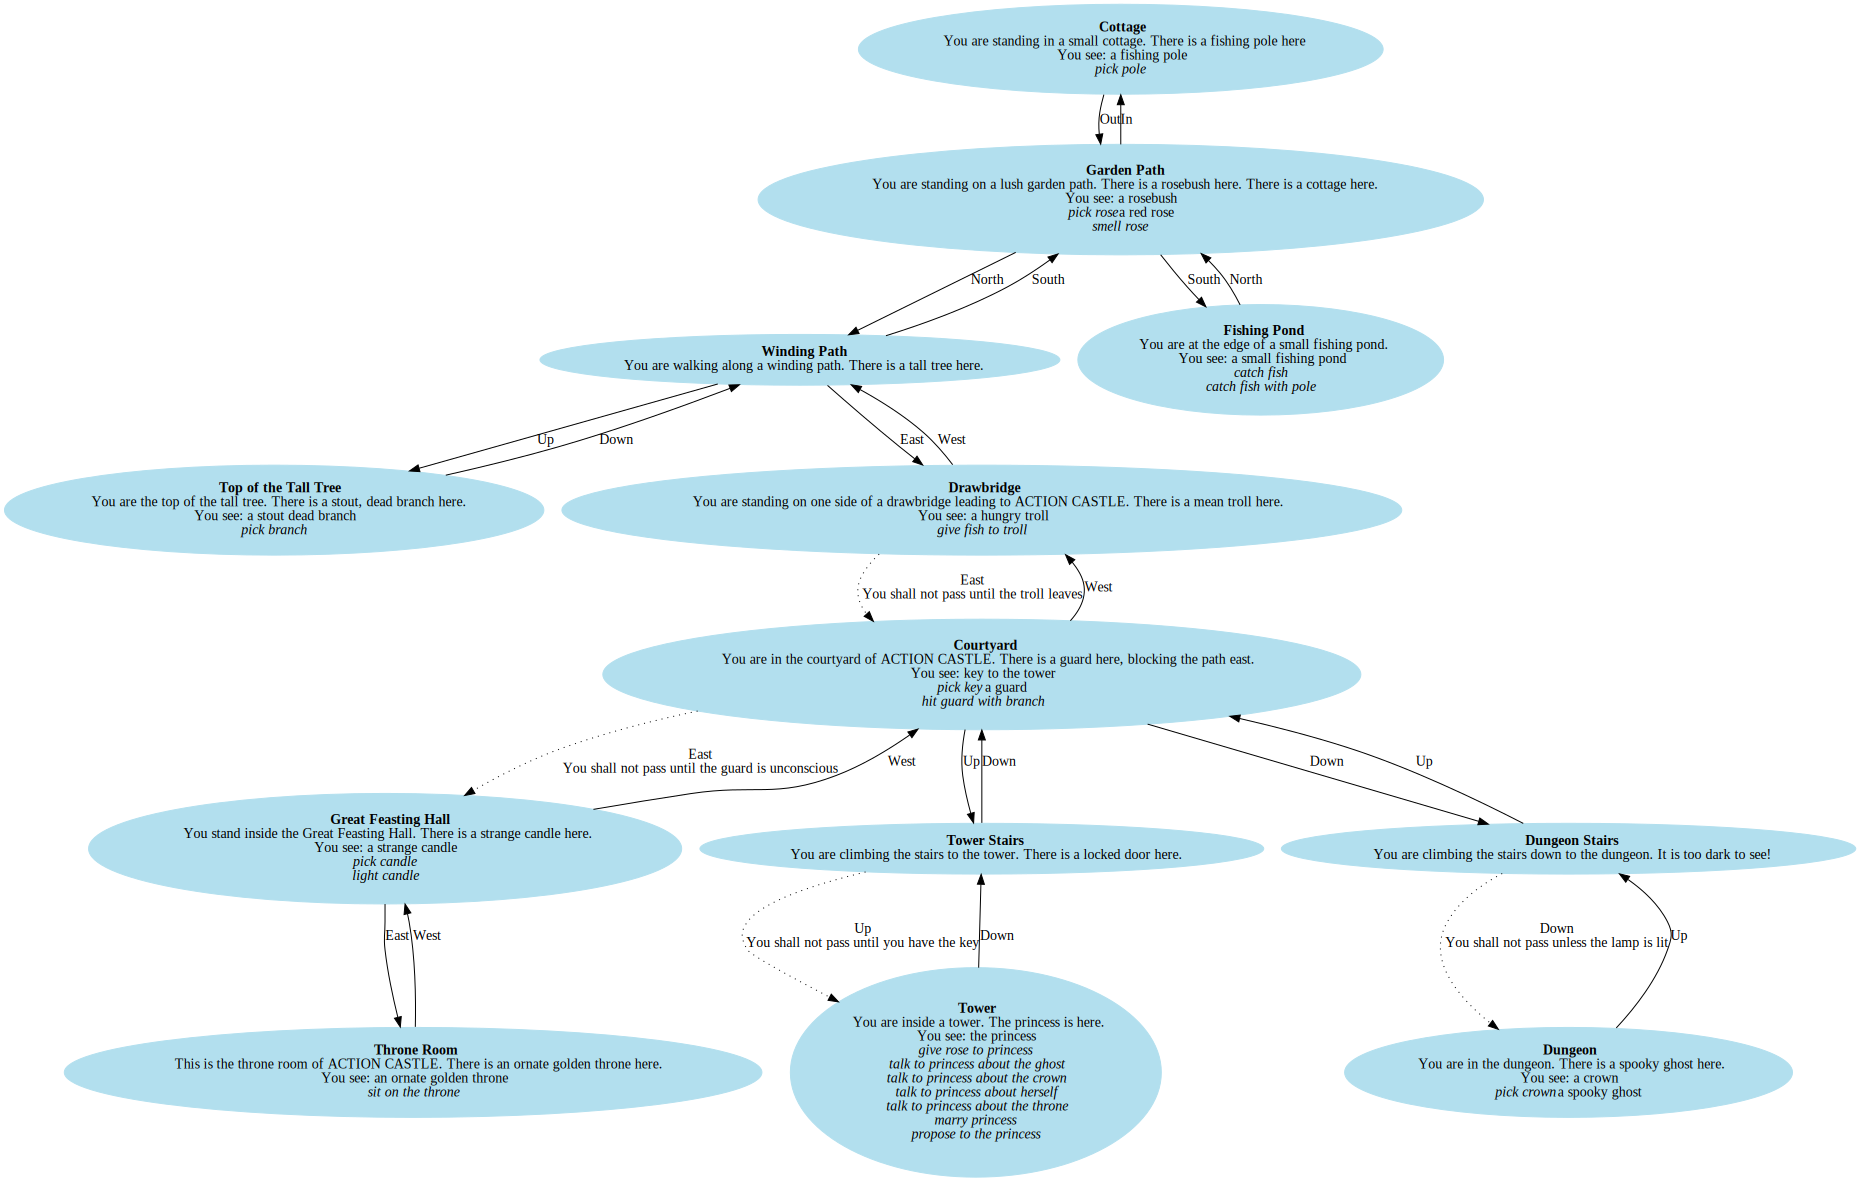

In [12]:
!pip install graphviz
from graphviz import Digraph
from IPython.display import Image
import queue

def DFS(game, graph):
  """Do a depth-first-search traversal of the locations in the game
     starting at the start location, and create a GraphViz graph 
     to vizualize the connections between the locations, and the items
     that are located at each location."""
  start_location = game.curr_location
  frontier = queue.Queue()
  frontier.put(start_location)
  visited = {}
  visited[start_location.name] = True

  while not frontier.empty():
    current_location = frontier.get()
    game.curr_location = current_location
    name = current_location.name
    description = current_location.description
    items = current_location.items
    items_html = describe_items(current_location)
    html = "<<b>%s</b><br />%s<br />%s>" % (name, description, items_html)
    # Create a new node in the graph for this location
    graph.node(name, label=html)  

    connections = current_location.connections
    for direction in connections.keys():
      next_location = connections[direction]
      if not current_location.is_blocked(direction, game):
        # Create an edge between the current location and its successor
        graph.edge(name, next_location.name, label=direction.capitalize())
      else:
        # Create a dotted edge for connected locations that are blocked
        block_description = "%s\n%s" % (direction.capitalize(), current_location.get_block_description(direction))
        graph.edge(name, next_location.name, label=block_description, style="dotted")
      if not next_location.name in visited:
        visited[next_location.name] = True
        frontier.put(next_location)

def describe_items(location, print_commands=True):
    """Describe what objects are in the current location."""
    items_html = ""
    if len(location.items.keys()) > 0:
      items_html = "You see: "
    for item_name in location.items:
      item = location.items[item_name]
      items_html += item.description
      if print_commands:
        special_commands = item.get_commands()
        for cmd in special_commands:
          items_html += "<br/><i>%s</i>" % cmd
    return items_html

def save_to_drive(graph):
  from google.colab import drive
  drive.mount('/content/drive/')
  graph.render('/content/drive/My Drive/game-visualization', view=True)  

graph = Digraph(node_attr={'color': 'lightblue2', 'style': 'filled'})
game = build_game()
DFS(game, graph)
#save_to_drive(graph)
graph.render('/Users/sohamp/Documents/UPenn_Acads/Sem4/hw1/graph_visualization', view=True)
graph
